In [1]:
import matplotlib.pyplot as plt
import numpy
import os

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# read dir and search for WHITE, DARK and OBJECT (RAW and HDR)
def readDir(dir_path):
    myDir = os.listdir(dir_path)
    print(myDir)
    dark_hdr =[]
    dark_raw=[]
    white_hdr=[]
    white_raw=[]
    for file in myDir:
        if 'dark' in file.lower() and 'hdr' in file.lower():
            #dark_hdr = dir_path + '/' + file
            dark_hdr = os.path.join(dir_path, file)
        if 'dark' in file.lower() and 'raw' in file.lower():
            #dark_raw = dir_path + '/' + file
            dark_raw = os.path.join(dir_path, file)
        if 'white' in file.lower() and 'hdr' in file.lower():
            #white_hdr = dir_path + '/' + file
            white_hdr = os.path.join(dir_path, file)
        if 'white' in file.lower() and 'raw' in file.lower():
            #white_raw = dir_path + '/' + file
            white_raw = os.path.join(dir_path, file)
        if (not 'white' in file.lower()) and (not 'dark' in file.lower()) and 'hdr' in file.lower():
            #object_hdr = dir_path + '/' + file
            object_hdr = os.path.join(dir_path, file)
        if (not 'white' in file.lower()) and (not 'dark' in file.lower()) and 'raw' in file.lower():
            #object_raw = dir_path + '/' + file
            object_raw = os.path.join(dir_path, file)
    return object_raw, object_hdr, white_raw, white_hdr, dark_raw, dark_hdr  

In [3]:
##### Read HDR content
def read_hdr(hdr_path):
    f=open(hdr_path, "r")
    filelines = f.readlines()
    #print(filelines)
    f.close()
    bands = ''
    for fileline in filelines:
        #print(fileline)
        if 'samples' in fileline.lower():
            samples = int(fileline.replace('samples = ',''))
            #print(samples)
        if bands =='' and 'bands' in fileline.lower():
            bands = int(fileline.replace('bands = ',''))
        if 'lines' in fileline.lower():
            lines = int(fileline.replace('lines = ',''))
    # read waves   
    print('Original Size: ', lines, bands, samples)
    n = 0
    for fileline in filelines:
        if 'th = {' in fileline.lower():
          #print(n)
          n1 = n+1
        n = n + 1
    n2 = n1 + bands
    #print(n1)
    #print(n2)
    waves = numpy.zeros(n2-n1,)
    n = 0
    for i in range(n1, n2):
        #print(filelines[i])
        waves[n] = float(filelines[i].replace(',',''))
        #print(waves[n])
        n = n + 1
    
    return samples, bands, lines, waves     

In [4]:
def read_raw(hdr_path, raw_path, line_start, line_read):
  #Read object hdr File
  [samples, bands, lines, waves] = read_hdr(hdr_path)
  fopen = open(raw_path, "rb")

  if (line_start == -1 or line_read == -1):
    # Read white or dark reference
    raw_white = numpy.fromfile(fopen, dtype=numpy.uint16)
    cube = numpy.reshape(raw_white, (lines, bands, samples))
  else:
    # Read object raw
    fopen.seek(samples*bands*line_start*2) # we skip 'line_start' number of lines
    raw_part = numpy.fromfile(fopen, dtype=numpy.uint16, count=samples*bands*line_read) # we read only 'line_read' number of lines
    cube = numpy.reshape(raw_part, (line_read, bands, samples))
    print('Resized to: ', cube.shape)
    print(waves)

  return cube, waves


In [5]:
def preview_RGB(spectral_cube, ch_1, ch_2, ch_3):
  lines, bands, samples = spectral_cube.shape
  RGB = numpy.empty((lines, samples, 3)) # Create a 'bmp' array with spatial size of ENVI 512,512 with 3 layers
  if (type(spectral_cube[0, 0, 0]) == numpy.uint16):
    RGB[:,:,0] = spectral_cube[:,ch_1,:]/numpy.amax(spectral_cube[:,ch_1,:]) # np.amax gets max value. Thus we get RGB in range [0,1]
    RGB[:,:,1] = spectral_cube[:,ch_2,:]/numpy.amax(spectral_cube[:,ch_2,:])
    RGB[:,:,2] = spectral_cube[:,ch_3,:]/numpy.amax(spectral_cube[:,ch_3,:])
  else:
    RGB[:,:,0] = spectral_cube[:,ch_1,:]
    RGB[:,:,1] = spectral_cube[:,ch_2,:]
    RGB[:,:,2] = spectral_cube[:,ch_3,:]
  plt.rcParams['figure.dpi'] = 200
  plt.imshow(RGB)
  plt.show()
  return RGB

In [6]:
def read_n_preview(path, line_start, line_read, ch_1, ch_2, ch_3):
  #Reading working directory
  [object_raw, object_hdr, white_raw, white_hdr, dark_raw, dark_hdr ] = readDir(path)

  #Read object spectral image
  [spectral_cube, waves] = read_raw(object_hdr, object_raw, line_start, line_read)
  object_RGB = preview_RGB(spectral_cube, ch_1, ch_2, ch_3)                         # Previewing spectral image in RGB

  #Read white reference
  [white_cube, w_waves] = read_raw(white_hdr, white_raw, -1, -1)
  w_RGB = preview_RGB(white_cube, ch_1, ch_2, ch_3)

  #Read dark hdr
  [dark_cube, d_waves] = read_raw(dark_hdr, dark_raw, -1, -1)
  d_RGB = preview_RGB(dark_cube, ch_1, ch_2, ch_3)

  return spectral_cube, object_RGB, white_cube, w_RGB, dark_cube, d_RGB, waves

In [7]:
def find_region_spectrum(cube, RGB, x1, x2, y1, y2):
  #Select an array
  RGB2 = RGB.copy()
  spectral_image = cube.copy()
  ##################################################################
  # Select pixels/ colour
  RGB2[y1:y2,x1:x2,0] = 0
  RGB2[y1:y2,x1:x2,1] = 1
  RGB2[y1:y2,x1:x2,2] = 0
  sel = spectral_image[y1:y2,:,x1:x2]
  sel1 = numpy.sum(sel, axis = 0)
  region = numpy.sum(sel1, axis =1)/((x2-x1)*(y2-y1))
  ##################################################################
  plt.rcParams['figure.dpi'] = 150
  plt.imshow(RGB2)
  plt.show()
  return region

In [8]:
def get_spectra(spectral_cube, object_RGB, white_cube, w_RGB, dark_cube, d_RGB, waves, x1, y1, title):
  region = find_region_spectrum(spectral_cube, object_RGB, x1, x1+15, y1, y1+15)    # Selecting region  
  #white_region = find_region_spectrum(white_cube, w_RGB, x1, x1+15, int(white_cube.shape[0]/2), int(white_cube.shape[0]/2) + 15)
  #dark_region = find_region_spectrum(dark_cube, d_RGB, x1, x1+15, int(dark_cube.shape[0]/2), int(dark_cube.shape[0]/2) + 15)
  white_region = find_region_spectrum(white_cube, w_RGB, x1, x1+15, 0, 1)
  dark_region = find_region_spectrum(dark_cube, d_RGB, x1, x1+15, 0, 1)

  #Plotting selected region, white and dark spectrum
  plt.plot(waves, white_region, "b")
  plt.plot(waves, region, "r")
  plt.plot(waves, dark_region, "g")
  plt.xlabel('Wavelength, um')
  plt.ylabel(title)
  plt.show()

  # White Correction - Only Region
  # region_corrected = (region-dark_region)/(white_region-dark_region)
  # plt.plot(waves, region_corrected, "r")

  # plt.xlabel('Wavelength, um')
  # plt.ylabel('Reflectance [0-100]%')
  # plt.show()

  # return region_corrected, waves


Main Code


['180.raw', '180.hdr', 'DARKREF_180.raw', 'DARKREF_180.hdr', 'WHITEREF_180.hdr', 'WHITEREF_180.raw']
Original Size:  512 204 512
Resized to:  (512, 204, 512)
[ 397.32  400.2   403.09  405.97  408.85  411.74  414.63  417.52  420.4
  423.29  426.19  429.08  431.97  434.87  437.76  440.66  443.56  446.45
  449.35  452.25  455.16  458.06  460.96  463.87  466.77  469.68  472.59
  475.5   478.41  481.32  484.23  487.14  490.06  492.97  495.89  498.8
  501.72  504.64  507.56  510.48  513.4   516.33  519.25  522.18  525.1
  528.03  530.96  533.89  536.82  539.75  542.68  545.62  548.55  551.49
  554.43  557.36  560.3   563.24  566.18  569.12  572.07  575.01  577.96
  580.9   583.85  586.8   589.75  592.7   595.65  598.6   601.55  604.51
  607.46  610.42  613.38  616.34  619.3   622.26  625.22  628.18  631.15
  634.11  637.08  640.04  643.01  645.98  648.95  651.92  654.89  657.87
  660.84  663.81  666.79  669.77  672.75  675.73  678.71  681.69  684.67
  687.65  690.64  693.62  696.61  699.6   

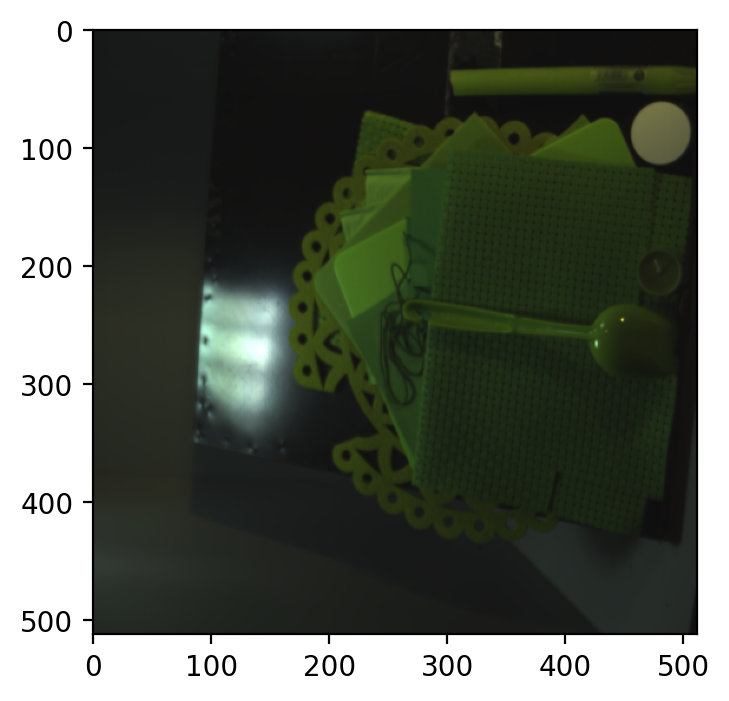

Original Size:  1 204 512


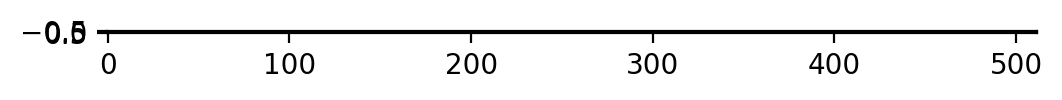

Original Size:  1 204 512


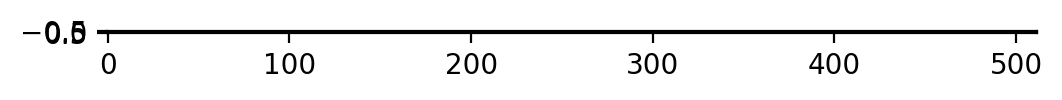

In [9]:
vis_path = '/content/drive/MyDrive/Summer School/ASI course 2021/Measurement sessions (Group5)/Group5_1/Specim IQ/180/capture'

# Resizing by line
line_start = 0
line_read = 512

ch_1 = 70 # Wavelength 631.15
ch_2 = 53 # Wavelength 528.03
ch_3 = 19 # Wavelength 443.56

[spectral_cube, object_RGB, white_cube, w_RGB, dark_cube, d_RGB, waves] = read_n_preview(vis_path, line_start, line_read, ch_1, ch_2, ch_3)

# Using advanced method for white correction

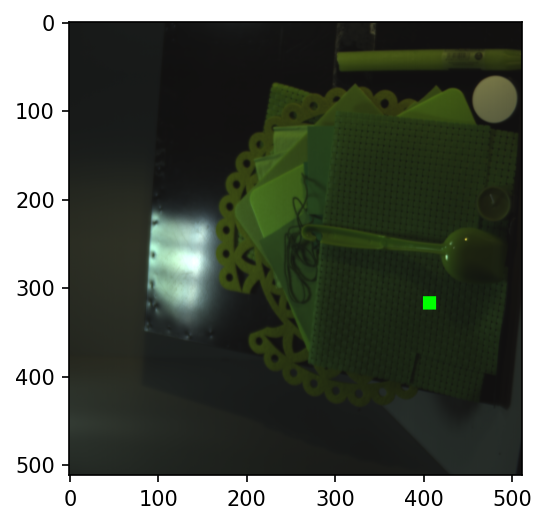

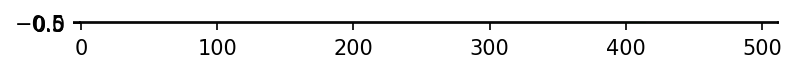

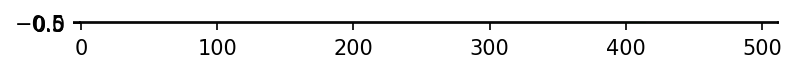

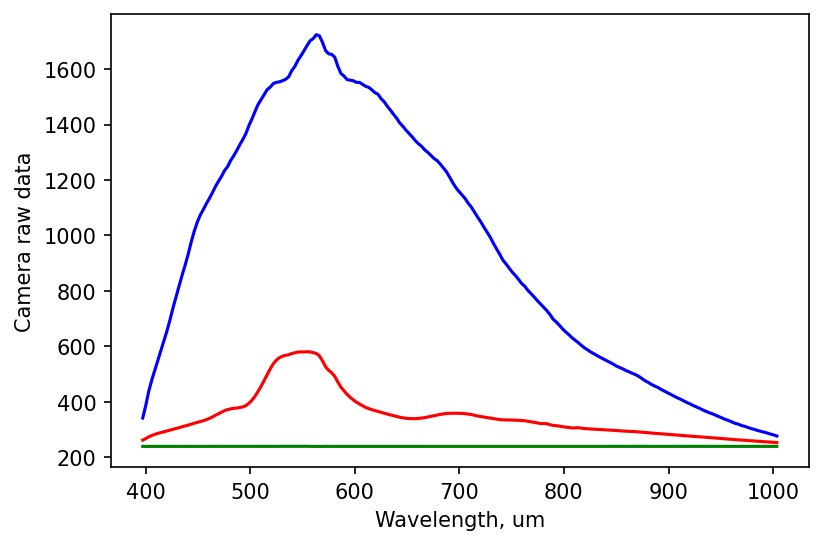

In [10]:
#Get Spectrum for VIS
get_spectra(spectral_cube, object_RGB, white_cube, w_RGB, dark_cube, d_RGB, waves, 400, 310, 'Camera raw data')

In [11]:
# White Correction - Advance method
def white_correction(spectral_cube, white_cube, dark_cube):
  [lines, bands, samples] = white_cube.shape
  white_av = numpy.sum(white_cube/lines, axis = 0)
  #print(white_cube.shape)
  #print(white_av.shape)
  [lines, bands, samples] = dark_cube.shape
  dark_av = numpy.sum(dark_cube/lines, axis = 0)

  [lines, bands, samples] = spectral_cube.shape
  #print(spectral_cube.shape)
  corrected_spectral_cube = numpy.zeros((lines, bands, samples), dtype=numpy.float32)
  for i in range(lines):
    corrected_spectral_cube[i,:,:] = numpy.divide(numpy.subtract(spectral_cube[i,:,:], dark_av), numpy.subtract(white_av, dark_av)) #numpy.divide(upper_part[i,:,:], lower_part)

  return corrected_spectral_cube

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


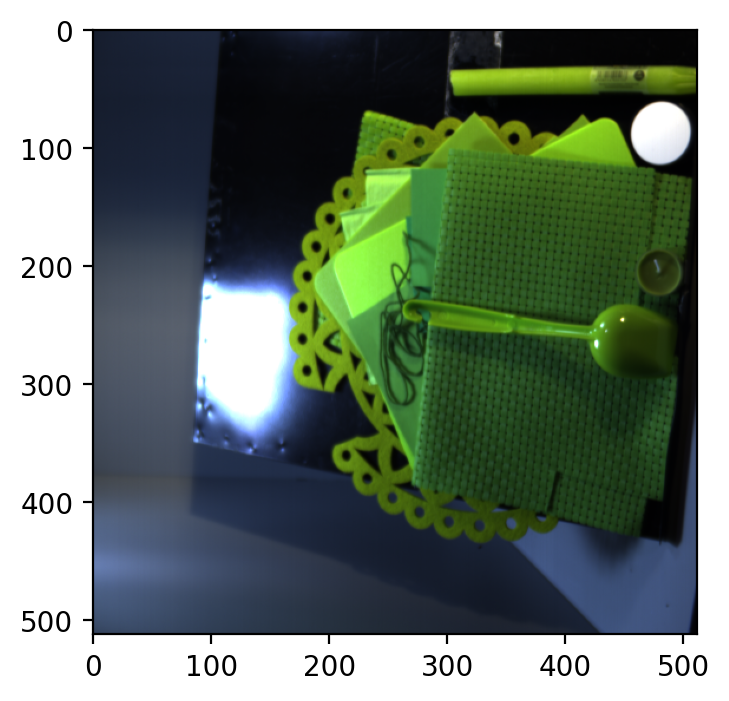

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


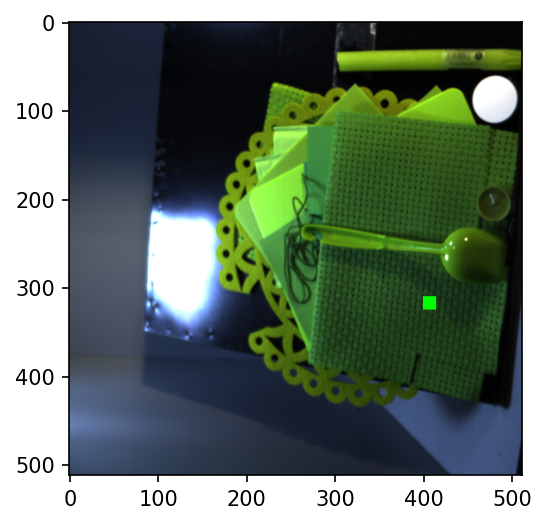

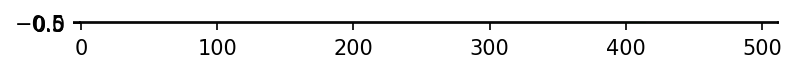

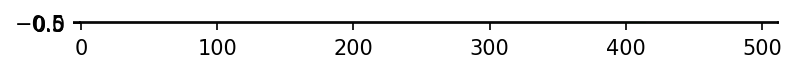

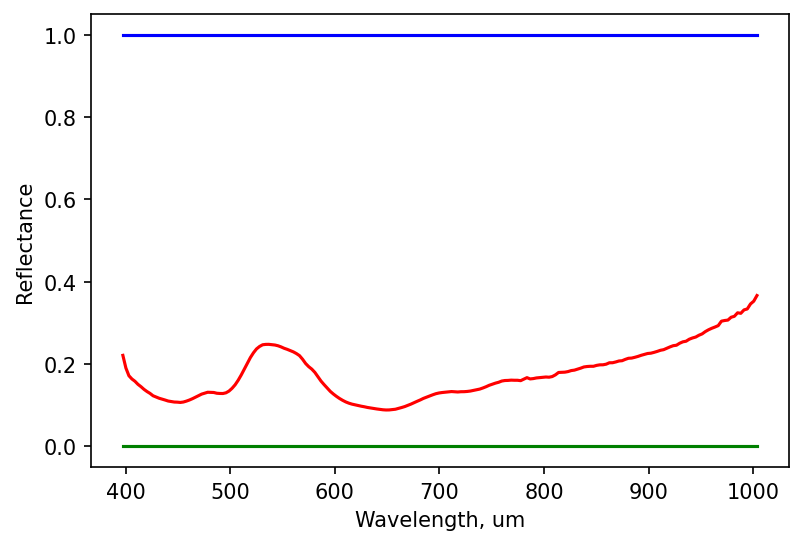

In [12]:
corr_spectral_cube = white_correction(spectral_cube, white_cube, dark_cube)
object_RGB = preview_RGB(corr_spectral_cube, ch_1, ch_2, ch_3)

get_spectra(corr_spectral_cube, object_RGB, white_cube/white_cube, w_RGB, 0/dark_cube, d_RGB, waves, 400, 310, 'Reflectance')

# Segmentation

In [13]:
def get_region_spectra(image_data, RGB, reg_x1, reg_y1):
  RGB2 = RGB.copy()
  ##################################################################
  # Select region
  x1 = reg_x1
  x2 = x1 + 20
  y1 = reg_y1
  y2 = y1 + 20

  RGB2[x1:x2,y1:y2,0] = 255
  sel = image_data[x1:x2,:,y1:y2]

  sel1 = numpy.sum(sel, axis = 0)
  selection1 = numpy.sum(sel1, axis =1)/((x2-x1)*(y2-y1))
  ##################################################################

  plt.imshow(RGB2)
  plt.rcParams['figure.dpi'] = 150
  plt.show()

  plt.plot(selection1) #plt.plot(waves,selection1)
  plt.xlabel('Wavelength, nm / bands')
  plt.ylabel('Reflectance [0-100]%')
  plt.title("Average spectrum of selected area")
  plt.show()
  
  return selection1

In [14]:
def segmentation(bands, threshold, selected, image_data, RGB):
  # Generate Band based condition
  n = len(bands) # the number of important bnds
  bbands = numpy.asarray(bands, dtype=numpy.uint16)

  # ratio is an array of ratios: ratio[n]=selcted[bbands[n+1]]/selected[bbands[n]]
  ratio = numpy.zeros(n-1) # array of ratios: ratio[n]=selcted[bbands[n+1]]/selected[bbands[n]]
  for i in range(n-1):
    ratio[i] = selected[bbands[i]]
  ###################################################################################################
  # now we make a new 'small_spectral_cube' made of selected bands from 'spectral_cube'
  [s1, s2, s3] = image_data.shape
  print(s1, s2, s3)
  small_spectral_cube = numpy.empty((s1, s3, n), dtype=numpy.float32)
  i=0
  for band in bbands:
    small_spectral_cube[:,:,i] = image_data[:,band,:]
    print(band)
    i=i+1
  print('RGB: ', RGB.shape)
  print('cube: ', image_data.shape)
  print('small cube: ', small_spectral_cube.shape)

  ###################################################################################################
  mask = RGB.copy()

  for i in range(s1):  #s1
    for j in range(s3): #s3
      criteria = 0
      for ch in range(n-1):
        #mask[i,j,0]=1
        if numpy.abs((small_spectral_cube[i,j,ch]-ratio[ch]))> threshold: #[0.02 - 0.18] threshold
          criteria = 1
          # ´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´
          gray_color = (mask[i,j,0] + mask[i,j,1] + mask[i,j,2])/3 # make mask gray scale and only selection RGB
          mask[i,j,0]=gray_color
          mask[i,j,1]=gray_color
          mask[i,j,2]=gray_color                       
          # ´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´
      if criteria == 0:
        pass

  print(numpy.amax(small_spectral_cube))
  print(numpy.amax(mask))
  print(numpy.amax(RGB))
  ###################################################################################################

  plt.show()
  plt.rcParams['figure.dpi'] = 200
  plt.imshow(mask)

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


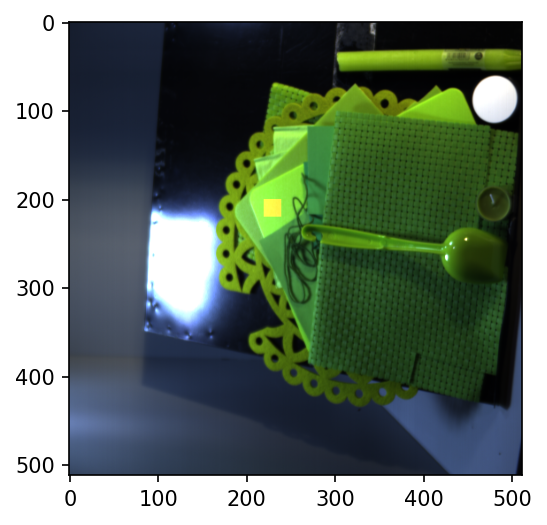

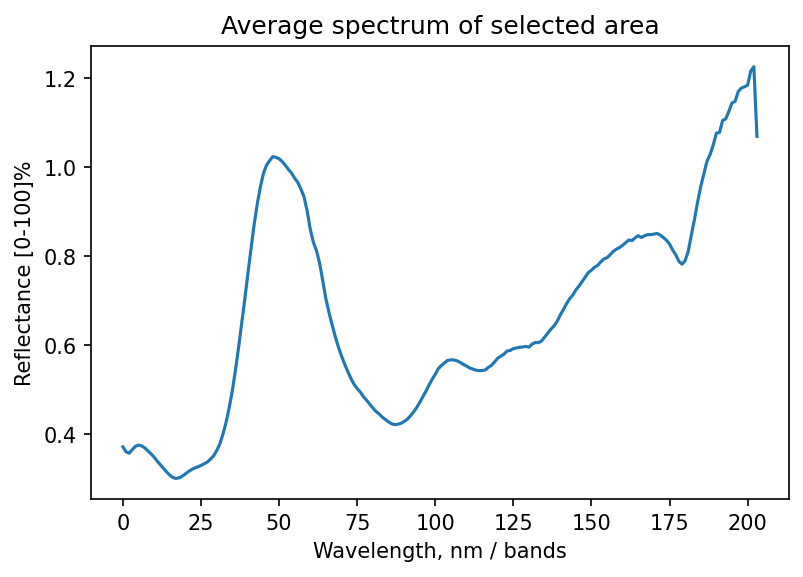

In [18]:
selection = get_region_spectra(corr_spectral_cube, object_RGB, 200, 220)

512 204 512
5
10
15
20
25
30
50
60
70
85
100
125
155
170
180
RGB:  (512, 512, 3)
cube:  (512, 204, 512)
small cube:  (512, 512, 15)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6.2750807
3.3584476312001548
4.6278510093688965


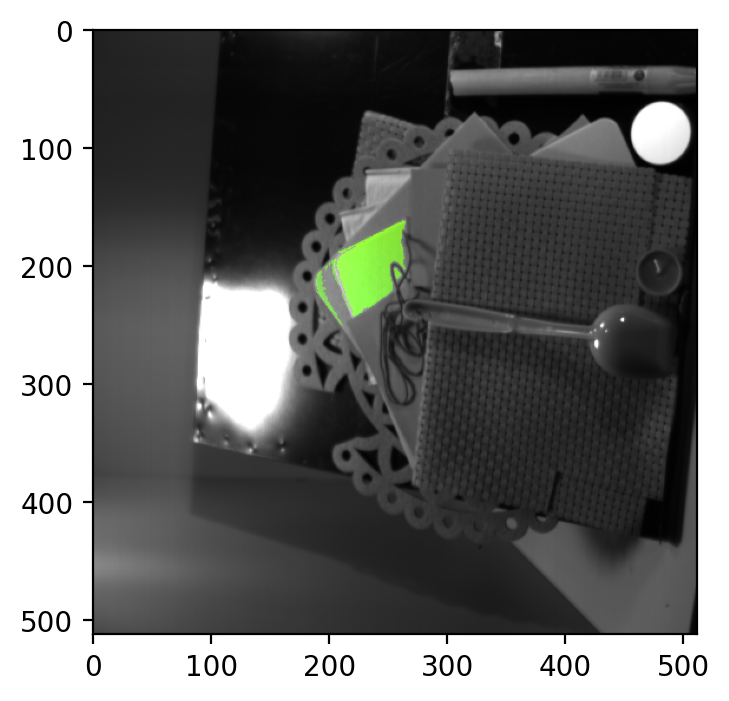

In [21]:
bands = [5, 10, 15, 20, 25, 30, 50, 60, 70, 85, 100, 125, 155, 170, 180]
segmentation(bands, 0.15, selection, corr_spectral_cube, object_RGB)